In [1]:
#Sankey plots
import os
os.chdir('/data/kkovacs/Python')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc

In [2]:
directory = '/data/kkovacs/Python'
#adata = sc.read(directory + "/Data/adata_all_pre.h5ad")
adata = sc.read(directory + "/Data/MLCA_All_meta_done_corrected.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 734896 × 43519
    obs: 'nCount_covid', 'nFeature_covid', 'orig.ident', 'Group', 'res.0', 'res.0.1', 'res.0.2', 'res.0.3', 'res.0.4', 'res.0.5', 'res.0.6', 'res.0.7', 'res.0.8', 'res.0.9', 'res.1', 'seurat_clusters', 'infection', 'cell_type', 'Mice', 'cell_label_short_0.6', 'nCount_covidneg', 'nFeature_covidneg', 'infection_neg', 'new_cell_type', 'study', 'CellTypes', 'CellTypes_short', 'samples', 'Timepoint', 'doublet', 'identifier.1', 'name', 'grouping', 'batch', 'cells', 'cluster', 'condition', 'age', 'sex', 'strain', 'treatment', 'tissue', 'time', 'platform', 'Tumor.or.healthy', 'Biological.replicate', 'Library', 'Barcode', 'Library.prep.batch', 'Total.counts', 'Percent.counts.from.mitochondrial.genes', 'Most.likely.Immgen.cell.type', 'Major.cell.type', 'Minor.subset', 'x', 'y', 'Geno', 'ID_old', 'hash.ID', 'SampleIDs', 'new.Celltypes', 'day', 'barcode', 'geo', 'predictions', 'clusters_1', 'clusters_2', 'clusters_3', 'n_genes_by_counts', 'total_

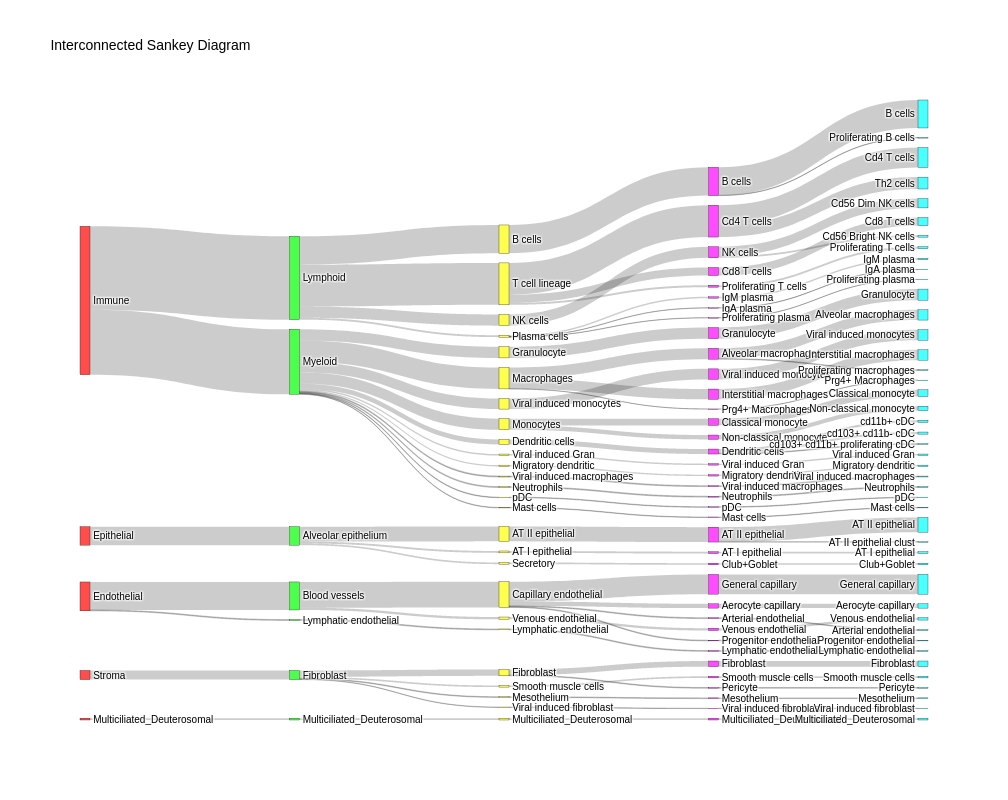

In [146]:
import pandas as pd
import plotly.graph_objects as go
levels = ['Level_1', 'Level_2', 'Level_3', 'Level_4', 'Level_5']

#levels = ['Level_1', 'Level_2', 'Level_3']

# Define colors for each level
level_colors = {
    'Level_1': 'rgba(255, 0, 0, 0.7)',    # Red
    'Level_2': 'rgba(0, 255, 0, 0.7)',    # Green
    'Level_2_5': 'rgba(0, 0, 255, 0.7)',  # Blue
    'Level_3': 'rgba(255, 255, 0, 0.7)',  # Yellow
    'Level_4': 'rgba(255, 0, 255, 0.7)',  # Purple
    'Level_5': 'rgba(0, 255, 255, 0.7)'   # Cyan
}

# Initialize dictionaries and data structures
node_labels = {}
level_counts = {}
flows = {}
node_x = {}

# Calculate counts for each level and store labels
for level in levels:
    level_counts[level] = adata.obs[level].value_counts()
    # Sort the labels based on the order of the index
    node_labels[level] = level_counts[level].index.tolist()

# Create a Plotly Sankey diagram
fig = go.Figure()

# Initialize lists to store node labels
node_labels_list = []

# Initialize lists to store links
source_nodes = []
target_nodes = []
values = []
link_labels = []

# Loop through each pair of source and target levels
for i in range(len(levels) - 1):
    source_level = levels[i]
    target_level = levels[i + 1]
    
    # Calculate flow values between levels iteratively
    source_counts = level_counts[source_level]
    target_counts = level_counts[target_level]
    
    # Initialize the flow matrix
    flow_matrix = pd.DataFrame(index=source_counts.index, columns=target_counts.index, data=0)
    
    # Calculate flow values based on common cell types
    for source_label in source_counts.index:
        for target_label in target_counts.index:
            common_cells = ((adata.obs[source_level] == source_label) & (adata.obs[target_level] == target_label)).sum()
            flow_matrix.loc[source_label, target_label] = common_cells
    
    flows[(source_level, target_level)] = flow_matrix.values
    
    # Ensure flow_data is a DataFrame
    flow_data = flows[(source_level, target_level)]
    source_labels = node_labels[source_level]
    target_labels = node_labels[target_level]
    flow_matrix = pd.DataFrame(flow_data, index=source_labels, columns=target_labels)
    
    # Create unique identifiers for nodes
    source_node_offset = len(node_labels_list)
    target_node_offset = len(node_labels_list) + len(source_labels)
    
    # Loop through the flow matrix and add links to the list, excluding zero values
    for source_label, source_row in flow_matrix.iterrows():
        for target_label, flow_value in source_row.items():
            if flow_value != 0:
                # Define labels with level prefixes
                source_node_label = f"{source_level}_{source_label}"
                target_node_label = f"{target_level}_{target_label}"
                
                # Check if the labels already exist in node_labels_list
                if source_node_label not in node_labels_list:
                    node_labels_list.append(source_node_label)
                if target_node_label not in node_labels_list:
                    node_labels_list.append(target_node_label)
                
                source_node = node_labels_list.index(source_node_label)
                target_node = node_labels_list.index(target_node_label)
                
                source_nodes.append(source_node)
                target_nodes.append(target_node)
                values.append(flow_value)
                link_labels.append(target_label)

node_colors = []
for node in node_labels_list:
    level_key = "_".join(node.split('_')[:2])
    if level_key == 'Level_2':
        if "_".join(node.split('_')[:3]) == 'Level_2_5':
            node_colors.append(level_colors.get("_".join(node.split('_')[:3]), 'rgba(128, 128, 128, 0.7)'))  # Assign new color for Level_2_5
        else:
            node_colors.append(level_colors.get(level_key, 'rgba(128, 128, 128, 0.7)'))  # Assign color for Level_2
    else:
        node_colors.append(level_colors.get(level_key, 'rgba(128, 128, 128, 0.7)'))  # Assign color for other levels

cleaned_node_labels = ['_'.join(label.split('_')[2:]) for label in node_labels_list]


new_node_labels = ['_'.join(label.split('_')[1:]) if label.startswith('5') else label for label in cleaned_node_labels]


# Add the x position to the nodes in the Sankey diagram
fig.add_trace(
    go.Sankey(
        arrangement = 'fixed',
        node=dict(
            pad=15,
            thickness=10,
            line=dict(color="black", width=0.3),
            label=new_node_labels,
            color=node_colors
        ),
        link=dict(
            source=source_nodes,
            target=target_nodes,
            value=values,
            label=link_labels,
        ),
    )
)
fig.update_layout(
    title='Interconnected Sankey Diagram',
    font=dict(size=10, color='black'),
	width=1000, 
    height=800,
    #2600,2200
    #1500,2000
)
#fig.update_traces(domain_y=list([0,0.5]), selector=dict(type='sankey'))
#fig.write_image("Sankey_color_1-2-3_hlca.png")

#fig.write_image("Sankey_color_final.png")

fig.show()

#import pickle
#with open('/data/kkovacs/Python/Sankey_final.pkl', 'wb') as file:
#    pickle.dump(fig, file)

#import pickle
#with open('/data/kkovacs/Python/Sankey_1-2-3.pkl', 'wb') as file:
#    pickle.dump(fig, file)


#with open(file_path, 'rb') as file:
#    loaded_fig = pickle.load(file)
